In [1]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd
from os import listdir
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l1,l2
import keras.backend as K
K.set_image_dim_ordering('tf')
import regex as re

dName = re.compile('_[A-Za-z0-9]*.mat')

tWindow = 25

def prepareData(data, tags):
    currFrame = 0
    retData = []
    retTags = []
    for index, row in tags.iterrows():
        start = (int(int(row[0])*25))
        stop = (int(int(row[1])*25))
        if(start != stop):
            retData.append(data[start:stop])
            retTags.append(1 if row[2] not in ["(nothing)", "multiple_actions"] else 0)
            currFrame = stop - 1
        else:
            if(start == currFrame):
                retTags[-1] = int(retTags[-1] or (1 if row[2] not in ["(nothing)", "multiple_actions"] else 0))
            else:
                retData.append(np.array([data[start]]))
                retTags.append(1 if row[2] not in ["(nothing)", "multiple_actions"] else 0)
                currFrame = stop
    return np.array(retData), np.array(retTags)

def flattenData(data, tags):
    residue = []
    retData = []
    retTags = []
    index = 0
    lastTag = 0
    for item in data:
        if(len(residue) > 0):
            item = np.concatenate((residue, item), axis = 0)
        if(len(item) >= tWindow):
            i = 0
            while(len(item) > i+tWindow):
                retData.append(item[i:i+tWindow])
                retTags.append(1 if ((len(residue) > 0 and lastTag == 1) or tags[index] == 1) else 0)
                i += tWindow
            if(len(item)%tWindow != 0):
                residue = item[i:len(item)]
            lastTag = tags[index]
        else:
            residue = item
            lastTag = 1 if (lastTag == 1 or tags[index] == 1) else 0
        index += 1
    if(len(residue) > 0):
        retData.append(np.concatenate((residue, np.zeros((tWindow-len(residue), 22))), axis = 0))
        retTags.append(1 if ((len(residue) > 0 and lastTag == 1) or tags[index-1] == 1) else 0)
    return np.array(retData), np.array(retTags)
        

Using TensorFlow backend.


In [2]:
dataPath = "./Datasets/VSD_2014_December_official_release/Hollywood-dev/features/"
annotationsPath = "./Datasets/VSD_2014_December_official_release/Hollywood-dev/annotations/"

data_names = listdir(annotationsPath)

uDataNames = set()

for fname in data_names:
    if ("screams" in fname):
        uDataNames.add(fname.replace('_screams.txt', ''))
        
uDataNames = list(uDataNames)

In [3]:
model = Sequential()
model.add(Conv1D(64, 6, activation='relu', input_shape=(tWindow, 22), kernel_initializer='uniform',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 2, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(3000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 64)            8512      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 256)            49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 256)            1024      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 256)            196864    
_________________________________________________________________
max_pooling1d_2 (MaxP

In [4]:
results = dict()
i = 0
for movie in uDataNames:
    print(movie)
    epVal = 60
    trainDataFile = h5py.File(dataPath + movie +"_auditory.mat")
    trainTags = pd.read_csv(annotationsPath + movie + "_screams.txt", sep = " ", header = None)

    trainData, trainTags = prepareData(np.array(trainDataFile.get("MFCC")), trainTags)
    ftrainData, ftrainTags = flattenData(trainData, trainTags)
    ftrainData = ftrainData.astype('float32')/3250
    
    results[movie] = model.fit(ftrainData, ftrainTags, epochs = epVal, validation_split = 0.2)
    i += 1
    print("Training advancement: ", int(float(i)/len(uDataNames)*100), "%")


TheWickerMan
Instructions for updating:
Use tf.cast instead.
Train on 4693 samples, validate on 1174 samples
Epoch 1/60
4693/4693 [==============================] - 9s 2ms/step - loss: 0.6771 - acc: 0.6269 - val_loss: 0.7179 - val_acc: 0.5153
Epoch 2/60
4693/4693 [==============================] - 3s 649us/step - loss: 0.6575 - acc: 0.6305 - val_loss: 0.7443 - val_acc: 0.4659
Epoch 3/60
4693/4693 [==============================] - 3s 632us/step - loss: 0.6554 - acc: 0.6397 - val_loss: 0.7151 - val_acc: 0.5170
Epoch 4/60
4693/4693 [==============================] - 3s 634us/step - loss: 0.6541 - acc: 0.6367 - val_loss: 0.7388 - val_acc: 0.5324
Epoch 5/60
4693/4693 [==============================] - 3s 630us/step - loss: 0.6523 - acc: 0.6388 - val_loss: 0.7579 - val_acc: 0.4540
Epoch 6/60
4693/4693 [==============================] - 3s 630us/step - loss: 0.6515 - acc: 0.6442 - val_loss: 0.7762 - val_acc: 0.3952
Epoch 7/60
4693/4693 [==============================] - 3s 645us/step - loss:

4693/4693 [==============================] - 3s 615us/step - loss: 0.6230 - acc: 0.6710 - val_loss: 0.8282 - val_acc: 0.3782
Epoch 59/60
4693/4693 [==============================] - 3s 633us/step - loss: 0.6220 - acc: 0.6701 - val_loss: 1.0034 - val_acc: 0.3492
Epoch 60/60
4693/4693 [==============================] - 3s 615us/step - loss: 0.6212 - acc: 0.6699 - val_loss: 0.7896 - val_acc: 0.5409
Training advancement:  5 %
TheSixthSense
Train on 4939 samples, validate on 1235 samples
Epoch 1/60
4939/4939 [==============================] - 3s 629us/step - loss: 0.6916 - acc: 0.5610 - val_loss: 0.5830 - val_acc: 0.7053
Epoch 2/60
4939/4939 [==============================] - 3s 616us/step - loss: 0.6728 - acc: 0.5859 - val_loss: 0.6652 - val_acc: 0.6445
Epoch 3/60
4939/4939 [==============================] - 3s 615us/step - loss: 0.6632 - acc: 0.6038 - val_loss: 0.6367 - val_acc: 0.6729
Epoch 4/60
4939/4939 [==============================] - 3s 615us/step - loss: 0.6593 - acc: 0.6111 - val

4939/4939 [==============================] - 3s 616us/step - loss: 0.3693 - acc: 0.8392 - val_loss: 1.2130 - val_acc: 0.7069
Epoch 58/60
4939/4939 [==============================] - 3s 614us/step - loss: 0.3872 - acc: 0.8303 - val_loss: 1.0592 - val_acc: 0.7717
Epoch 59/60
4939/4939 [==============================] - 3s 611us/step - loss: 0.3763 - acc: 0.8334 - val_loss: 1.0004 - val_acc: 0.5563
Epoch 60/60
4939/4939 [==============================] - 3s 612us/step - loss: 0.3694 - acc: 0.8372 - val_loss: 1.2321 - val_acc: 0.5887
Training advancement:  11 %
BillyElliot
Train on 5076 samples, validate on 1270 samples
Epoch 1/60
5076/5076 [==============================] - 3s 627us/step - loss: 0.6338 - acc: 0.7384 - val_loss: 0.7455 - val_acc: 0.6346
Epoch 2/60
5076/5076 [==============================] - 3s 614us/step - loss: 0.5607 - acc: 0.7520 - val_loss: 0.8385 - val_acc: 0.5819
Epoch 3/60
5076/5076 [==============================] - 3s 612us/step - loss: 0.5377 - acc: 0.7589 - val

5076/5076 [==============================] - 3s 608us/step - loss: 0.1330 - acc: 0.9604 - val_loss: 2.2399 - val_acc: 0.6252
Epoch 57/60
5076/5076 [==============================] - 3s 614us/step - loss: 0.1244 - acc: 0.9622 - val_loss: 2.4433 - val_acc: 0.6331
Epoch 58/60
5076/5076 [==============================] - 3s 613us/step - loss: 0.1190 - acc: 0.9669 - val_loss: 1.8917 - val_acc: 0.6496
Epoch 59/60
5076/5076 [==============================] - 3s 610us/step - loss: 0.1162 - acc: 0.9679 - val_loss: 5.2341 - val_acc: 0.4362
Epoch 60/60
5076/5076 [==============================] - 3s 611us/step - loss: 0.1182 - acc: 0.9636 - val_loss: 4.3550 - val_acc: 0.5016
Training advancement:  17 %
TheBourneIdentity
Train on 5447 samples, validate on 1362 samples
Epoch 1/60
5447/5447 [==============================] - 3s 627us/step - loss: 0.7003 - acc: 0.7336 - val_loss: 0.4254 - val_acc: 0.8935
Epoch 2/60
5447/5447 [==============================] - 3s 617us/step - loss: 0.5640 - acc: 0.757

5447/5447 [==============================] - 3s 615us/step - loss: 0.0680 - acc: 0.9835 - val_loss: 1.1530 - val_acc: 0.7922
Epoch 56/60
5447/5447 [==============================] - 3s 615us/step - loss: 0.0571 - acc: 0.9892 - val_loss: 1.1381 - val_acc: 0.7658
Epoch 57/60
5447/5447 [==============================] - 3s 617us/step - loss: 0.0583 - acc: 0.9866 - val_loss: 0.7873 - val_acc: 0.8473
Epoch 58/60
5447/5447 [==============================] - 3s 615us/step - loss: 0.0566 - acc: 0.9877 - val_loss: 1.0048 - val_acc: 0.9104
Epoch 59/60
5447/5447 [==============================] - 3s 613us/step - loss: 0.0473 - acc: 0.9917 - val_loss: 1.4788 - val_acc: 0.6791
Epoch 60/60
5447/5447 [==============================] - 3s 614us/step - loss: 0.0641 - acc: 0.9855 - val_loss: 1.0715 - val_acc: 0.8488
Training advancement:  23 %
Armageddon
Train on 6793 samples, validate on 1699 samples
Epoch 1/60
6793/6793 [==============================] - 4s 623us/step - loss: 0.8004 - acc: 0.6106 - va

6793/6793 [==============================] - 4s 615us/step - loss: 0.1017 - acc: 0.9731 - val_loss: 3.5602 - val_acc: 0.4220
Epoch 55/60
6793/6793 [==============================] - 4s 657us/step - loss: 0.0868 - acc: 0.9801 - val_loss: 5.0452 - val_acc: 0.4014
Epoch 56/60
6793/6793 [==============================] - 4s 637us/step - loss: 0.0895 - acc: 0.9785 - val_loss: 3.3080 - val_acc: 0.6586
Epoch 57/60
6793/6793 [==============================] - 4s 620us/step - loss: 0.0932 - acc: 0.9789 - val_loss: 3.3972 - val_acc: 0.6886
Epoch 58/60
6793/6793 [==============================] - 4s 613us/step - loss: 0.0888 - acc: 0.9804 - val_loss: 3.4363 - val_acc: 0.6115
Epoch 59/60
6793/6793 [==============================] - 4s 623us/step - loss: 0.0837 - acc: 0.9825 - val_loss: 5.0707 - val_acc: 0.4885
Epoch 60/60
6793/6793 [==============================] - 4s 636us/step - loss: 0.0855 - acc: 0.9809 - val_loss: 2.7696 - val_acc: 0.5280
Training advancement:  29 %
Leon
Train on 5075 sample

5075/5075 [==============================] - 3s 631us/step - loss: 0.1039 - acc: 0.9726 - val_loss: 1.1555 - val_acc: 0.9054
Epoch 54/60
5075/5075 [==============================] - 3s 631us/step - loss: 0.0991 - acc: 0.9722 - val_loss: 1.3589 - val_acc: 0.8400
Epoch 55/60
5075/5075 [==============================] - 3s 617us/step - loss: 0.1012 - acc: 0.9760 - val_loss: 1.4474 - val_acc: 0.9110
Epoch 56/60
5075/5075 [==============================] - 3s 624us/step - loss: 0.1004 - acc: 0.9708 - val_loss: 1.1515 - val_acc: 0.9078
Epoch 57/60
5075/5075 [==============================] - 3s 646us/step - loss: 0.0997 - acc: 0.9746 - val_loss: 2.8410 - val_acc: 0.6328
Epoch 58/60
5075/5075 [==============================] - 3s 633us/step - loss: 0.0872 - acc: 0.9789 - val_loss: 1.6379 - val_acc: 0.7991
Epoch 59/60
5075/5075 [==============================] - 3s 621us/step - loss: 0.0939 - acc: 0.9764 - val_loss: 1.4514 - val_acc: 0.8290
Epoch 60/60
5075/5075 [==============================

6590/6590 [==============================] - 4s 612us/step - loss: 0.1959 - acc: 0.9352 - val_loss: 3.2440 - val_acc: 0.7712
Epoch 53/60
6590/6590 [==============================] - 4s 612us/step - loss: 0.1998 - acc: 0.9305 - val_loss: 3.0536 - val_acc: 0.7925
Epoch 54/60
6590/6590 [==============================] - 4s 616us/step - loss: 0.2006 - acc: 0.9361 - val_loss: 1.4846 - val_acc: 0.7100
Epoch 55/60
6590/6590 [==============================] - 4s 613us/step - loss: 0.1896 - acc: 0.9405 - val_loss: 2.4763 - val_acc: 0.7688
Epoch 56/60
6590/6590 [==============================] - 4s 613us/step - loss: 0.1870 - acc: 0.9370 - val_loss: 2.6341 - val_acc: 0.6220
Epoch 57/60
6590/6590 [==============================] - 4s 613us/step - loss: 0.1772 - acc: 0.9445 - val_loss: 3.3825 - val_acc: 0.7900
Epoch 58/60
6590/6590 [==============================] - 4s 609us/step - loss: 0.1828 - acc: 0.9385 - val_loss: 3.0955 - val_acc: 0.7773
Epoch 59/60
6590/6590 [==============================

4568/4568 [==============================] - 3s 610us/step - loss: 0.1552 - acc: 0.9496 - val_loss: 3.3829 - val_acc: 0.7776
Epoch 52/60
4568/4568 [==============================] - 3s 611us/step - loss: 0.1555 - acc: 0.9523 - val_loss: 3.4938 - val_acc: 0.7802
Epoch 53/60
4568/4568 [==============================] - 3s 612us/step - loss: 0.1418 - acc: 0.9521 - val_loss: 3.3270 - val_acc: 0.7767
Epoch 54/60
4568/4568 [==============================] - 3s 609us/step - loss: 0.1409 - acc: 0.9545 - val_loss: 3.5333 - val_acc: 0.7802
Epoch 55/60
4568/4568 [==============================] - 3s 614us/step - loss: 0.1345 - acc: 0.9617 - val_loss: 3.4639 - val_acc: 0.7793
Epoch 56/60
4568/4568 [==============================] - 3s 613us/step - loss: 0.1403 - acc: 0.9571 - val_loss: 3.1003 - val_acc: 0.7793
Epoch 57/60
4568/4568 [==============================] - 3s 615us/step - loss: 0.1394 - acc: 0.9593 - val_loss: 3.4564 - val_acc: 0.7811
Epoch 58/60
4568/4568 [==============================

6360/6360 [==============================] - 4s 614us/step - loss: 0.3397 - acc: 0.8684 - val_loss: 0.2608 - val_acc: 0.9485
Epoch 51/60
6360/6360 [==============================] - 4s 614us/step - loss: 0.3294 - acc: 0.8728 - val_loss: 0.2116 - val_acc: 0.9843
Epoch 52/60
6360/6360 [==============================] - 4s 611us/step - loss: 0.3342 - acc: 0.8712 - val_loss: 0.2244 - val_acc: 0.9874
Epoch 53/60
6360/6360 [==============================] - 4s 611us/step - loss: 0.3217 - acc: 0.8730 - val_loss: 0.2256 - val_acc: 0.9868
Epoch 54/60
6360/6360 [==============================] - 4s 614us/step - loss: 0.3184 - acc: 0.8747 - val_loss: 0.2247 - val_acc: 0.9874
Epoch 55/60
6360/6360 [==============================] - 4s 610us/step - loss: 0.3207 - acc: 0.8780 - val_loss: 0.3017 - val_acc: 0.9535
Epoch 56/60
6360/6360 [==============================] - 4s 612us/step - loss: 0.3214 - acc: 0.8719 - val_loss: 0.3987 - val_acc: 0.9082
Epoch 57/60
6360/6360 [==============================

4681/4681 [==============================] - 3s 640us/step - loss: 0.3942 - acc: 0.8203 - val_loss: 2.0150 - val_acc: 0.7344
Epoch 50/60
4681/4681 [==============================] - 3s 615us/step - loss: 0.3845 - acc: 0.8235 - val_loss: 2.9807 - val_acc: 0.5944
Epoch 51/60
4681/4681 [==============================] - 3s 621us/step - loss: 0.3867 - acc: 0.8253 - val_loss: 7.8474 - val_acc: 0.3399
Epoch 52/60
4681/4681 [==============================] - 3s 646us/step - loss: 0.3815 - acc: 0.8259 - val_loss: 8.9842 - val_acc: 0.2596
Epoch 53/60
4681/4681 [==============================] - 3s 624us/step - loss: 0.3841 - acc: 0.8304 - val_loss: 9.4074 - val_acc: 0.2562
Epoch 54/60
4681/4681 [==============================] - 3s 613us/step - loss: 0.3861 - acc: 0.8300 - val_loss: 1.1632 - val_acc: 0.7532
Epoch 55/60
4681/4681 [==============================] - 3s 637us/step - loss: 0.3768 - acc: 0.8334 - val_loss: 3.1750 - val_acc: 0.5781
Epoch 56/60
4681/4681 [==============================

5927/5927 [==============================] - 4s 629us/step - loss: 0.4964 - acc: 0.7543 - val_loss: 1.5095 - val_acc: 0.6572
Epoch 49/60
5927/5927 [==============================] - 4s 676us/step - loss: 0.4986 - acc: 0.7608 - val_loss: 4.9277 - val_acc: 0.3475
Epoch 50/60
5927/5927 [==============================] - 4s 668us/step - loss: 0.4928 - acc: 0.7643 - val_loss: 4.5355 - val_acc: 0.6356
Epoch 51/60
5927/5927 [==============================] - 4s 645us/step - loss: 0.4849 - acc: 0.7663 - val_loss: 2.9657 - val_acc: 0.4069
Epoch 52/60
5927/5927 [==============================] - 4s 670us/step - loss: 0.4858 - acc: 0.7633 - val_loss: 4.7756 - val_acc: 0.3441
Epoch 53/60
5927/5927 [==============================] - 4s 641us/step - loss: 0.4790 - acc: 0.7678 - val_loss: 10.4255 - val_acc: 0.2443
Epoch 54/60
5927/5927 [==============================] - 5s 775us/step - loss: 0.4715 - acc: 0.7744 - val_loss: 4.4812 - val_acc: 0.3543
Epoch 55/60
5927/5927 [=============================

6396/6396 [==============================] - 4s 615us/step - loss: 0.3702 - acc: 0.8419 - val_loss: 2.0838 - val_acc: 0.5804
Epoch 48/60
6396/6396 [==============================] - 4s 615us/step - loss: 0.3732 - acc: 0.8437 - val_loss: 0.4506 - val_acc: 0.9468
Epoch 49/60
6396/6396 [==============================] - 4s 615us/step - loss: 0.3781 - acc: 0.8394 - val_loss: 0.7175 - val_acc: 0.9543
Epoch 50/60
6396/6396 [==============================] - 4s 615us/step - loss: 0.4217 - acc: 0.8182 - val_loss: 0.6143 - val_acc: 0.9531
Epoch 51/60
6396/6396 [==============================] - 4s 614us/step - loss: 0.4110 - acc: 0.8205 - val_loss: 0.7032 - val_acc: 0.9575
Epoch 52/60
6396/6396 [==============================] - 4s 614us/step - loss: 0.4060 - acc: 0.8233 - val_loss: 0.6835 - val_acc: 0.8130
Epoch 53/60
6396/6396 [==============================] - 4s 611us/step - loss: 0.4036 - acc: 0.8261 - val_loss: 1.2466 - val_acc: 0.6798
Epoch 54/60
6396/6396 [==============================

4780/4780 [==============================] - 3s 616us/step - loss: 0.4062 - acc: 0.8230 - val_loss: 2.2261 - val_acc: 0.4833
Epoch 47/60
4780/4780 [==============================] - 3s 615us/step - loss: 0.4014 - acc: 0.8287 - val_loss: 1.5834 - val_acc: 0.5050
Epoch 48/60
4780/4780 [==============================] - 3s 614us/step - loss: 0.4021 - acc: 0.8299 - val_loss: 2.1903 - val_acc: 0.4875
Epoch 49/60
4780/4780 [==============================] - 3s 614us/step - loss: 0.3916 - acc: 0.8291 - val_loss: 1.3567 - val_acc: 0.5594
Epoch 50/60
4780/4780 [==============================] - 3s 617us/step - loss: 0.3904 - acc: 0.8312 - val_loss: 2.0414 - val_acc: 0.4841
Epoch 51/60
4780/4780 [==============================] - 3s 614us/step - loss: 0.3960 - acc: 0.8328 - val_loss: 2.4786 - val_acc: 0.4732
Epoch 52/60
4780/4780 [==============================] - 3s 617us/step - loss: 0.3779 - acc: 0.8385 - val_loss: 2.0280 - val_acc: 0.5585
Epoch 53/60
4780/4780 [==============================

4476/4476 [==============================] - 3s 648us/step - loss: 0.3909 - acc: 0.8494 - val_loss: 1.1308 - val_acc: 0.6917
Epoch 46/60
4476/4476 [==============================] - 3s 649us/step - loss: 0.3911 - acc: 0.8523 - val_loss: 1.2161 - val_acc: 0.5156
Epoch 47/60
4476/4476 [==============================] - 3s 654us/step - loss: 0.3931 - acc: 0.8501 - val_loss: 2.0271 - val_acc: 0.3289
Epoch 48/60
4476/4476 [==============================] - 3s 651us/step - loss: 0.3881 - acc: 0.8528 - val_loss: 1.6813 - val_acc: 0.4048
Epoch 49/60
4476/4476 [==============================] - 3s 649us/step - loss: 0.3968 - acc: 0.8487 - val_loss: 1.2389 - val_acc: 0.5156
Epoch 50/60
4476/4476 [==============================] - 3s 647us/step - loss: 0.3808 - acc: 0.8575 - val_loss: 2.0885 - val_acc: 0.5380
Epoch 51/60
4476/4476 [==============================] - 3s 651us/step - loss: 0.3841 - acc: 0.8579 - val_loss: 2.0481 - val_acc: 0.3110
Epoch 52/60
4476/4476 [==============================

Epoch 44/60
7787/7787 [==============================] - 5s 640us/step - loss: 0.5604 - acc: 0.7009 - val_loss: 0.9144 - val_acc: 0.5737
Epoch 45/60
7787/7787 [==============================] - 5s 639us/step - loss: 0.5559 - acc: 0.6998 - val_loss: 3.8936 - val_acc: 0.5865
Epoch 46/60
7787/7787 [==============================] - 5s 640us/step - loss: 0.5524 - acc: 0.6980 - val_loss: 3.9922 - val_acc: 0.3970
Epoch 47/60
7787/7787 [==============================] - 5s 639us/step - loss: 0.5494 - acc: 0.7035 - val_loss: 1.3811 - val_acc: 0.5624
Epoch 48/60
7787/7787 [==============================] - 5s 644us/step - loss: 0.5513 - acc: 0.7099 - val_loss: 2.5750 - val_acc: 0.5912
Epoch 49/60
7787/7787 [==============================] - 5s 640us/step - loss: 0.5448 - acc: 0.7051 - val_loss: 3.4257 - val_acc: 0.4135
Epoch 50/60
7787/7787 [==============================] - 5s 638us/step - loss: 0.5426 - acc: 0.7162 - val_loss: 1.1800 - val_acc: 0.5378
Epoch 51/60
7787/7787 [==================

7065/7065 [==============================] - 5s 641us/step - loss: 0.3612 - acc: 0.8541 - val_loss: 0.4805 - val_acc: 0.8251
Epoch 44/60
7065/7065 [==============================] - 5s 640us/step - loss: 0.3613 - acc: 0.8541 - val_loss: 0.6032 - val_acc: 0.7340
Epoch 45/60
7065/7065 [==============================] - 4s 637us/step - loss: 0.3591 - acc: 0.8545 - val_loss: 1.3371 - val_acc: 0.3831
Epoch 46/60
7065/7065 [==============================] - 5s 639us/step - loss: 0.3543 - acc: 0.8568 - val_loss: 0.4324 - val_acc: 0.8602
Epoch 47/60
7065/7065 [==============================] - 5s 638us/step - loss: 0.3582 - acc: 0.8551 - val_loss: 0.5489 - val_acc: 0.8755
Epoch 48/60
7065/7065 [==============================] - 4s 633us/step - loss: 0.3525 - acc: 0.8617 - val_loss: 0.7676 - val_acc: 0.6576
Epoch 49/60
7065/7065 [==============================] - 4s 630us/step - loss: 0.3540 - acc: 0.8580 - val_loss: 0.6240 - val_acc: 0.7312
Epoch 50/60
7065/7065 [==============================

5564/5564 [==============================] - 3s 624us/step - loss: 0.5423 - acc: 0.7239 - val_loss: 1.4225 - val_acc: 0.5352
Epoch 43/60
5564/5564 [==============================] - 3s 620us/step - loss: 0.5362 - acc: 0.7365 - val_loss: 2.3569 - val_acc: 0.5697
Epoch 44/60
5564/5564 [==============================] - 3s 625us/step - loss: 0.5518 - acc: 0.7229 - val_loss: 3.7446 - val_acc: 0.5726
Epoch 45/60
5564/5564 [==============================] - 3s 623us/step - loss: 0.5393 - acc: 0.7317 - val_loss: 3.6451 - val_acc: 0.5812
Epoch 46/60
5564/5564 [==============================] - 3s 622us/step - loss: 0.5450 - acc: 0.7272 - val_loss: 5.6499 - val_acc: 0.5718
Epoch 47/60
5564/5564 [==============================] - 3s 621us/step - loss: 0.5434 - acc: 0.7329 - val_loss: 1.5613 - val_acc: 0.5862
Epoch 48/60
5564/5564 [==============================] - 3s 623us/step - loss: 0.5429 - acc: 0.7336 - val_loss: 5.1823 - val_acc: 0.5754
Epoch 49/60
5564/5564 [==============================

In [6]:
for key, value in results.items():
    plt.figure(1, figsize=(10,10))
    plt.plot(value.history['loss'])
    plt.plot(value.history['acc'])
    plt.plot(value.history['val_loss'])
    plt.plot(value.history['val_acc'])
    plt.title(f'{key} training plot')
    plt.ylabel('value')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'train acc', 'test loss', 'test acc'], loc='upper left')
    plt.savefig(f'{key}.png')
    plt.close(1)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("modelv4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelv4.h5")
print("Saved model to disk")

In [7]:
testPath = "./Datasets/VSD_2014_December_official_release/YouTube-gen/features/"

test_names = listdir(testPath)

uTestNames = set()

for fname in test_names:
    uTestNames.add(fname.replace(dName.search(fname).group(), ''))
        
uTestNames = list(uTestNames)

y5wshpExmWM


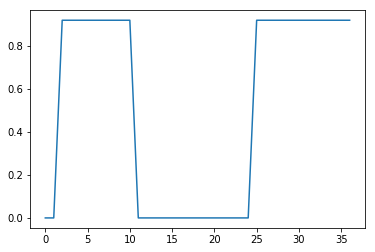

In [11]:
testName = uTestNames[rnd.randint(0, len(uTestNames) - 1)]
print(testName)
testDataFile = h5py.File(testPath + testName +"_auditory.mat")
testData = np.array(testDataFile.get("MFCC"))
result = []

i = 0
while(len(testData) > i+tWindow):
    prepare = testData[i:i+tWindow]
    prepare = prepare.astype('float32')/3250
    result.append(model.predict(np.expand_dims(testData[i:i+tWindow], axis = 0)))
    i += tWindow
    
if(len(testData)%tWindow != 0):
    residue = np.concatenate((testData[i:len(testData)], np.zeros(((tWindow-(len(testData)%tWindow)), 22))), axis = 0)
    result.append(model.predict(np.expand_dims(residue, axis = 0))[0])

plt.plot(result)